# Exploring GAN conditioning

Using the models investigated before we aim to improve the inductive bias of the training by modifying the model to accept also global properties of the jet.
- [x] cGAN model
- [ ] other conditions?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import kl_div

In [2]:
# load data

e = np.loadtxt("./PythiaMomenta.csv",delimiter=",")
e_split = np.split(e,len(e)/8)
events = np.stack(e_split)
print(events.shape)

(1000000, 8, 4)


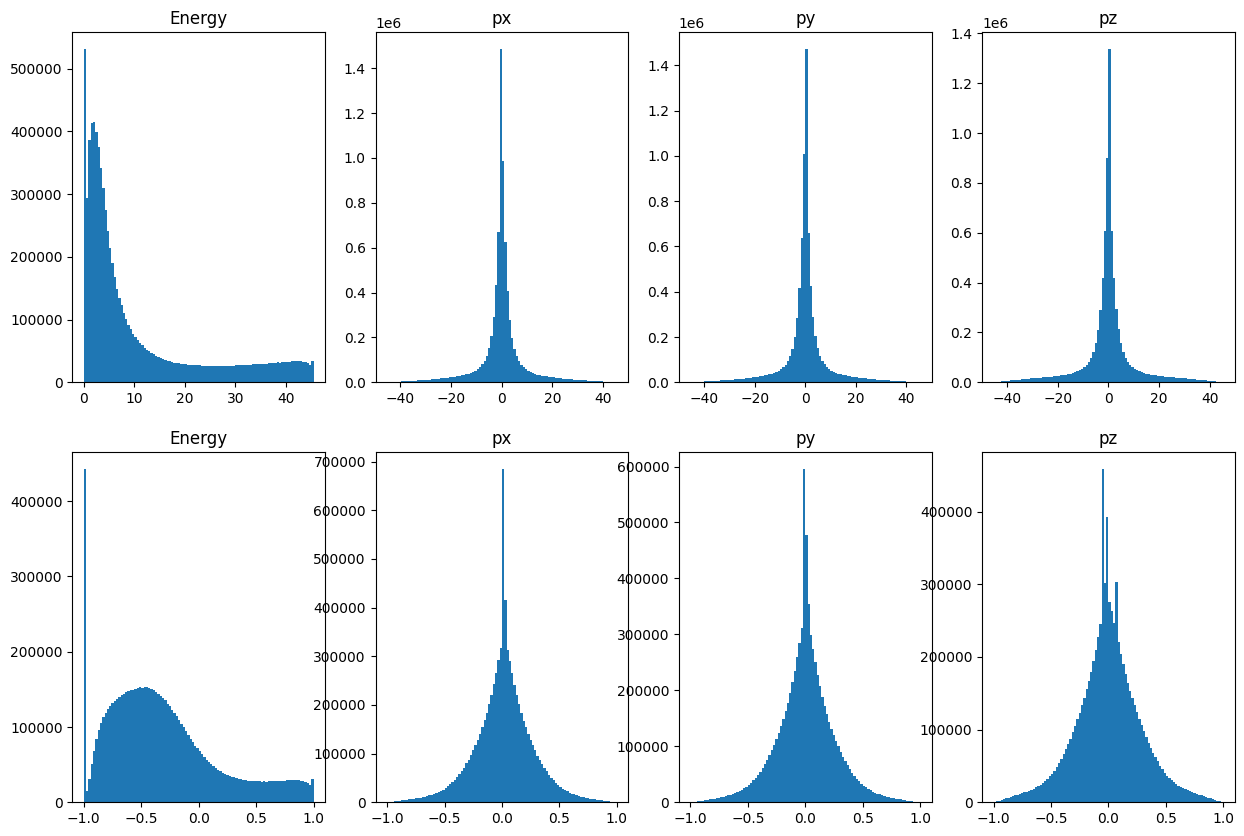

In [3]:
# explore to limits

fig,(ax1,ax2) = plt.subplots(2,4,figsize=(15,10))
ax1[0].hist(events[:,:,0].flatten(),bins=100)
ax1[0].set_title("Energy")
ax1[1].hist(events[:,:,1].flatten(),bins=100)
ax1[1].set_title("px")
ax1[2].hist(events[:,:,2].flatten(),bins=100)
ax1[2].set_title("py")
ax1[3].hist(events[:,:,3].flatten(),bins=100)
ax1[3].set_title("pz")

# normalise all 8 x 3 features with MinMaxScaler
minmax_events = events.copy()
scalers = np.zeros((8,4),dtype=object)
for i in range(8):
    for j in range(4):
        scalers[i,j] = MinMaxScaler((-1,1)).fit(events[:,i,j].reshape(-1,1))
        minmax_events[:,i,j] = scalers[i,j].transform(events[:,i,j].reshape(-1,1)).flatten()

ax2[0].hist(minmax_events[:,:,0].flatten(),bins=100)
ax2[0].set_title("Energy")
ax2[1].hist(minmax_events[:,:,1].flatten(),bins=100)
ax2[1].set_title("px")
ax2[2].hist(minmax_events[:,:,2].flatten(),bins=100)
ax2[2].set_title("py")
ax2[3].hist(minmax_events[:,:,3].flatten(),bins=100)
ax2[3].set_title("pz");

In [4]:
# some parameters
gen_dim = 4
conds_dim = gen_dim
num_hadron = 8
noise_dim = 64
BATCH_SIZE = 8
n_epochs = 100


In [5]:
event_globs = np.ones((events.shape[0],events.shape[2]))
# each event will have the total energy, px_tot, py_tot, pz_tot

for i in range(4):
    event_globs[:,i] = np.sum(events[:,:,i],axis=1)

In [6]:
c_train, c_valid, x_train, x_valid = train_test_split(event_globs, events, test_size=0.99)

# load into tensorflow dataset dtype as float32
#pythia_dataset = tf.data.Dataset.from_tensor_slices((event_globs.astype(np.float32), x_train.astype(np.float32)))
pythia_dataset = tf.data.Dataset.from_tensor_slices((c_train.astype(np.float32), x_train.astype(np.float32)))
pythia_dataset = pythia_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

print(f"Shape of training images: {x_train.shape}")

Shape of training images: (10000, 8, 4)


2024-07-23 18:53:12.788108: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-23 18:53:12.788135: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-23 18:53:12.788147: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-23 18:53:12.788363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-23 18:53:12.788385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def Generator():
    inp_conds = tf.keras.layers.Input(shape=[conds_dim, ], name='condition_G')
    inp_noise = tf.keras.layers.Input(shape=[noise_dim, ], name='noise')
    x = tf.keras.layers.concatenate([inp_conds, inp_noise], axis=1)
    x = tf.keras.layers.Dense(32, activation='LeakyReLU')(x)
    x = tf.keras.layers.Dense(64, activation='LeakyReLU')(x)
    x = tf.keras.layers.Dense(64, activation='LeakyReLU')(x)
    x = tf.keras.layers.Dense(num_hadron*gen_dim, activation="sigmoid")(x)
    last = tf.keras.layers.Reshape((num_hadron, gen_dim))(x)
    return tf.keras.Model(inputs=[inp_conds, inp_noise], outputs=last, name='Generator')

def Discriminator():
    inp_c = tf.keras.layers.Input(shape=(conds_dim,), name='condition_D')
    inp_x = tf.keras.layers.Input(shape=(num_hadron, gen_dim), name='target')
    x = tf.keras.layers.Flatten()(inp_x)
    X = tf.keras.layers.concatenate([inp_c, x], axis=1)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dense(16, activation='relu')(X)
    last = tf.keras.layers.Dense(1)(X)
    return tf.keras.Model(inputs=[inp_c, inp_x], outputs=last, name='Discriminator')

In [8]:

generator = Generator()
discriminator = Discriminator()
generator.build((None, [4,noise_dim]))
discriminator.build((None,[4,[num_hadron, gen_dim]]))
print(generator.summary())
print(discriminator.summary())

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 condition_G (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 noise (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 68)                   0         ['condition_G[0][0]',         
                                                                     'noise[0][0]']               
                                                                                                  
 dense (Dense)               (None, 32)                   2208      ['concatenate[0][0]'] 

In [9]:
generator = Generator()
discriminator = Discriminator()

print(generator.summary())
print(discriminator.summary())

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 condition_G (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 noise (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 68)                   0         ['condition_G[0][0]',         
 )                                                                   'noise[0][0]']               
                                                                                                  
 dense_8 (Dense)             (None, 32)                   2208      ['concatenate_2[0][0]'

In [10]:
lambda_reg = 0.5
def discriminator_loss(D_real, D_fake, penalty):
    D_loss = tf.reduce_mean(D_fake - D_real + lambda_reg * penalty)
    return D_loss

def generator_loss(D_fake):
    G_loss = -tf.reduce_mean(D_fake)
    return G_loss

## Generator optimizer and Discriminator optimizer
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4, beta_1=0.5, beta_2=0.9)


## Gradient penalty to the Discriminator loss ##
def penalty_calculation(X_real, G_fake, condition):
    # Create the gradient penalty operations.
    epsilon = tf.random.uniform(shape=tf.shape(X_real), minval=0, maxval=1.)
    interpolation = epsilon * X_real + (1 - epsilon) * G_fake

    with tf.GradientTape() as pena_tape:
        pena_tape.watch(interpolation)
        penalty = (
                tf.norm(
                    pena_tape.gradient(discriminator([condition, interpolation]), interpolation),
                    axis=1
                ) - 1 
        ) ** 2.0
    return penalty

## Train Generator and Discriminator independently  ##
@tf.function
def train_G(data_batch):
    noise = tf.random.normal(
            [data_batch[0].shape[0], noise_dim], 
            mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
    )
    condition = data_batch[0]
    
    with tf.GradientTape() as gen_tape:
        G_fake = generator([condition, noise], training=True)
        D_fake = discriminator([condition, G_fake], training=True)
        G_loss = generator_loss(D_fake)
    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return G_loss

@tf.function
def train_D(data_batch):
    noise = tf.random.normal(
        [data_batch[0].shape[0], noise_dim], 
        mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
    )
    condition = data_batch[0]
    target = data_batch[1]
    
    with tf.GradientTape() as disc_tape:
        G_fake = generator([condition, noise], training=True)
        D_real = discriminator([condition, target], training=True)
        D_fake = discriminator([condition, G_fake], training=True)
        penalty = penalty_calculation(target, G_fake, condition)
        D_loss = discriminator_loss(D_real, D_fake, penalty)
    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return D_loss

In [11]:
from IPython import display

def train(dataset, epochs, D_cycle=1, steps_show=10, show_display=True):
    start = time.time()
    loss_G_train = []
    loss_D_train = []
    
    fig, axs = plt.subplots(1,1, figsize=(7,7))
    
    for epoch in range(epochs):
        for data_batch in dataset:
            G_loss = train_G(data_batch)
            for _ in range(D_cycle):
                D_loss = train_D(data_batch)
        
        loss_G_train.append(G_loss.numpy())
        loss_D_train.append(D_loss.numpy())
                
        if (epoch+1) % steps_show ==0:
            noise = tf.random.normal([c_valid.shape[0], noise_dim],
                                     mean=0.0, stddev=1.0, 
                                     dtype=tf.dtypes.float32)
            
            x_wcgan = generator(
                [c_valid, noise], training=True
            )
            x_wcgan = x_wcgan.numpy()

            axs.clear()
            axs.plot(-np.array(loss_D_train), label = 'negative D loss')
            axs.plot(-np.array(loss_G_train), label = 'negative G loss')
            
            axs.set_xlabel("epochs")
            axs.set_ylabel("negative loss")
            axs.legend()
            
            fig.canvas.draw()
            fig.canvas.flush_events()
            
            if show_display:
                display.clear_output(wait=True)
                display.display(fig)
            # plt.pause(0.00001)
            # time.sleep(0.00001)
            
        if (epoch+1 )% 5 ==0:     
            print ('Time for epoch {}/{} is {} sec'.format(epoch+1,epochs, time.time()-start))
            start = time.time()
            
    fig.show()
    return loss_G_train, loss_D_train, fig

In [ ]:
loss_G_train, loss_D_train, figure = train(
    pythia_dataset, 
    epochs=100, 
    D_cycle=1, 
    steps_show=1, show_display=True
)

Time for epoch 5/100 is 49.99558115005493 sec


In [ ]:
# and inspect the results
noise = tf.random.normal(
            [c_valid.shape[0], noise_dim], 
            mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
generated_data = generator([c_valid, noise], training=True)
generated_data = generated_data

# and plot
features = ["Energy","px","py","pz"]
fig,ax = plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    _,b,_= ax[i].hist(generated_data[:,0,i].numpy().flatten(),bins=100,label="lead",alpha=0.5)
    ax[i].hist(generated_data[:,1,i].numpy().flatten(),bins=b,label="sublead",alpha=0.5)
    ax[i].hist(generated_data[:,2,i].numpy().flatten(),bins=b,label="subsublead",alpha=0.5)
    ax[i].set_title(features[i])
    ax[i].legend()
    ax[i].set_yscale('log')

In [ ]:
generated_data = generated_data.numpy()
# scale generated data back to match the original data
for i in range(num_hadron):
    for j in range(gen_dim):
        generated_data[:,i,j] = scalers[i,j].inverse_transform(generated_data[:,i,j].reshape(-1,1)).flatten()

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    _,b,_= ax[i].hist(generated_data[:,0,i],bins=100,label="lead",alpha=0.5)
    ax[i].hist(generated_data[:,1,i],bins=b,label="sublead",alpha=0.5)
    ax[i].hist(generated_data[:,2,i],bins=b,label="subsublead",alpha=0.5)
    ax[i].set_title(features[i])
    ax[i].legend()
    ax[i].set_yscale('log')

In [ ]:
fig,(ax,bx) = plt.subplots(2,4,figsize=(15,5), sharex=True)
for i in range(4):
    pythia_bins,b = np.histogram(x_valid[:,0,i],bins=100,density=True)
    gan_bins,_ = np.histogram(generated_data[:,0,i],bins=b,density=True )
    # calculate KL divergence between GAN and Pythia for this feature
    kl_lead = kl_div(gan_bins,pythia_bins).sum()
    ax[i].hist(x_valid[:,0,i],bins=b,label="Pythia lead",alpha=0.5,density=True)
    ax[i].hist(generated_data[:,0,i],bins=b,label="GAN kl={:.2f}".format(kl_lead),alpha=.5,density=True)
    
    pythia_bins,b = np.histogram(x_valid[:,1,i],bins=100,density=True)
    gan_bins,_ = np.histogram(generated_data[:,1,i],bins=b,density=True)
    kl_sub = kl_div(gan_bins,pythia_bins).sum()
    bx[i].hist(x_valid[:,1,i],bins=b,label="Pythia sublead",alpha=0.5,density=True)
    bx[i].hist(generated_data[:,1,i],bins=b,label="GAN kl={:.2f}".format(kl_sub),alpha=.5,density=True)
    
    ax[i].set_title(features[i])
    ax[i].legend()
    bx[i].legend()


In [ ]:
ECM = 91.0

def dot(q1,q2):
    y = q1[1]*q2[1]+q1[2]*q2[2]+q1[3]*q2[3]
    return y

def z_angle(p1,p2):
    if dot(p1,p1)==0.0 or dot(p2,p2) == 0:
        cos_phi = 1.0
    else:
        cos_phi = dot(p1,p2)/(np.sqrt(dot(p1,p1))*np.sqrt(dot(p2,p2)))
    z = (1.0-cos_phi)/2.0    
    return z

def EEC(lst):
    EEC_list = []
    for i in range(lst.shape[0]):
        for j in range(lst.shape[1]):
            for k in range(lst.shape[1]):
                if j!=k:
                    z = z_angle(lst[i,j],lst[i,k])
                    w = lst[i,j,0]*lst[i,k,0]/((ECM**2.0))
                    EEC_list.append((z,w))
    return EEC_list

In [ ]:
eec_synthetic = EEC(generated_data)
eec_pythia = EEC(events)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
# eec are pairs of angles and weights
bins = np.logspace(-3,0,75)

pyt,_,_ = ax.hist([x[0] for x in eec_pythia],bins=bins,weights=[x[1] for x in eec_pythia], alpha=0.5,label="pythia", density=True)
gen,_ = np.histogram([x[0] for x in eec_synthetic],bins=bins,weights=[x[1] for x in eec_synthetic], density=True)
kl_eec = kl_div(gen,pyt).sum()
gen,_,_ = ax.hist([x[0] for x in eec_synthetic],bins=bins,weights=[x[1] for x in eec_synthetic] , alpha=0.5,label="synthetic kl = {:.2f}".format(kl_eec), density=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$R_L$")
ax.set_ylabel("Normalised EEc")
ax.legend();